In [16]:
from scipy.interpolate import CubicHermiteSpline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from time import time
from tabulate import tabulate
import sympy 
from decimal import Decimal, getcontext, localcontext

In [17]:
def plot_fun(f, a, b, label="", color="r", step=0.01, ax=plt, title="Wykres funkcji", dec=False):
    n = int((b-a)/step)+1
    x = np.linspace(a,b,n)
    if dec:
        x = [Decimal(xi) for xi in x]
    ax.plot(x, [f(xi) for xi in x], color=color, label=label)
    if label:
        ax.legend(loc="best")

    if ax is plt:
        ax.title(title)
        ax.xlabel("x")
        ax.ylabel("y")
    else:
        ax.set_title(title)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
    ax.grid()

In [18]:
def abs_diff(f, W, x):
    return [abs(f(xi)-float(W(xi))) for xi in x]

def max_diff(f, W, x):
    return max(abs_diff(f, W, x))

def mean_square_error(f, W, x):
    return sum(d ** 2 for d in abs_diff(f, W, x))

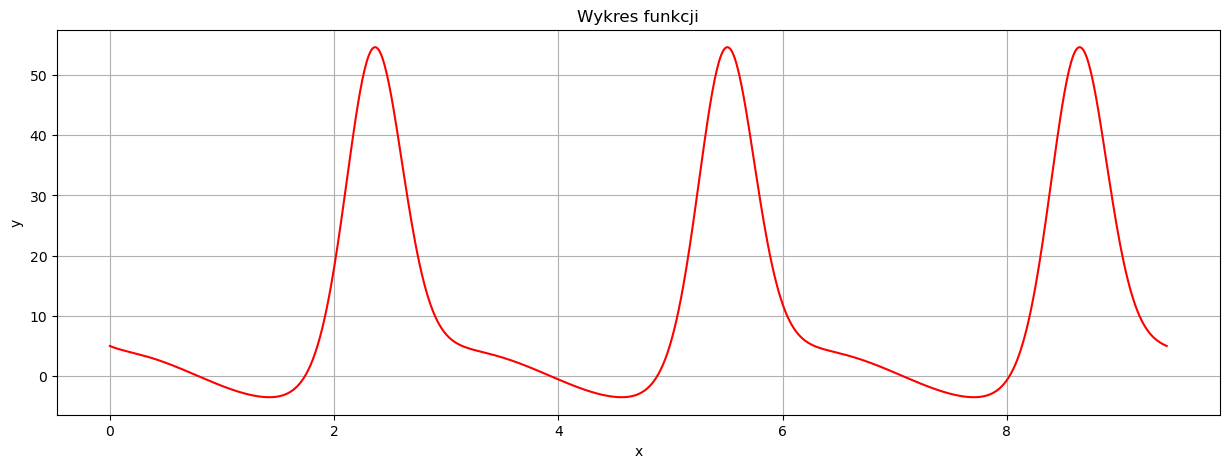

In [19]:
f = lambda x, k, m: math.e**(-k*math.sin(m*x)) + k*math.cos(m*x) 

g = lambda x: f(x, 4, 2)

a, b = 0, 3*math.pi

plt.figure(figsize=(15,5))
plot_fun(g, 0, 3*math.pi)
plt.show()

In [20]:
def czebyszew_node(a, b, n):
    return [0.5*(a+b)+0.5*(b-a)*math.cos((2*i - 1)/(2*n)*math.pi) for i in range(n, 0, -1)]

def hermit(x: list[int], y: list[list[int]]):
    m = [len(l) for l in y]
    n = sum(m) - 1 # deg of polynominal
    res_x = []
    for i in range(len(x)):
        res_x.extend([x[i]]*m[i])

    coef = [[None]*(n+1) for _ in range(n+1)]

    k = 0
    for sublist in y:
        for i in range(len(sublist)):
            for j in range(i+1):
                coef[k][j] = sublist[j] / math.factorial(j)
            k += 1

    for i in range(1, n+1):
        for j in range(i, n+1):
            if coef[j][i] is not None:
                continue
            coef[j][i] = (coef[j][i-1] - coef[j-1][i-1])/(res_x[j]-res_x[j-i])
    
    coef = [coef[i][i] for i in range(n+1)]

    def f(x0):
        diff = [x0 - xi for xi in x]
        y0 = coef[0]
        p1 = 1
        deg = 0
        for i, mi in enumerate(m):
            for _ in range(mi):
                deg += 1
                p1 *= diff[i]
                y0 += coef[deg]*p1
                if deg == n:
                    return y0

    return f

"""def hermit_scpiy(g, a, b, n, N, nodes=np.linspace, title=""):
    X = sympy.Symbol('X')
    f = sympy.exp(-4*sympy.sin(2*X)) + 4*sympy.cos(2*X) 
    f1 = f.diff(X)
    f1_call = sympy.lambdify(X, f1)

    x = nodes(a, b, n)
    y = [f.subs(X, xi) for xi in x]
    dydx = [f1_call(xi) for xi in x]

    W = CubicHermiteSpline(x, y, dydx)

    fig, ax = plt.subplots(1, figsize=(15,4))

    plot_fun(g, a, b, step=.01, color='pink', label='funkcja początkowa', ax=ax, title=title)
    plot_fun(W, a, b, step=.01, color='green', label='interpolacja Hermita', ax=ax, title=title)

    ax.scatter(x, y, color="black", s=10)

    plt.show()
    
    return W"""


'def hermit_scpiy(g, a, b, n, N, nodes=np.linspace, title=""):\n    X = sympy.Symbol(\'X\')\n    f = sympy.exp(-4*sympy.sin(2*X)) + 4*sympy.cos(2*X) \n    f1 = f.diff(X)\n    f1_call = sympy.lambdify(X, f1)\n\n    x = nodes(a, b, n)\n    y = [f.subs(X, xi) for xi in x]\n    dydx = [f1_call(xi) for xi in x]\n\n    W = CubicHermiteSpline(x, y, dydx)\n\n    fig, ax = plt.subplots(1, figsize=(15,4))\n\n    plot_fun(g, a, b, step=.01, color=\'pink\', label=\'funkcja początkowa\', ax=ax, title=title)\n    plot_fun(W, a, b, step=.01, color=\'green\', label=\'interpolacja Hermita\', ax=ax, title=title)\n\n    ax.scatter(x, y, color="black", s=10)\n\n    plt.show()\n    \n    return W'

In [21]:
x = sympy.Symbol('x')
fs = sympy.exp(-4*sympy.sin(2*x)) + 4*sympy.cos(2*x) 
fs1 = fs.diff(x)
fs2 = fs1.diff(x)
fs3 = fs2.diff(x)

f1 = sympy.lambdify(x, fs1)
f2 = sympy.lambdify(x, fs2)
f3 = sympy.lambdify(x, fs3)

derivatives = [g, f1, f2]

In [22]:
def error(f, W, label, a, b, N):
    x = np.linspace(a,b,N)
    diffs = abs_diff(f,W,x)
    print(tabulate([
        ("Błąd bezwzględny:", max(diffs)),
        ("Suma kwadratów róznic:", sum(xi**2 for xi in diffs))
    ], [
        f"Interpolacja {label}"
    ], tablefmt="fancy_grid", floatfmt=f'.{6}f'))

def plot_interpolation(f, x, y, N=1000, title="", show_err=False):
    W = hermit(x, y)

    fig, ax = plt.subplots(1, figsize=(15,4))

    plot_fun(f, a, b, step=0.01, color="black", label="f(x)= e^(-4sin(2x)) + 4cos(2x)", ax=ax)
    plot_fun(W, a, b, step=0.01, label="Interpolacja Hermita", color="red", ax=ax, title=title)
    ax.scatter(x, [sublist[0] for sublist in y], color="green")

    plt.show()
    if show_err:
        error(f,W,"Interpolacja Hermita\n", a,b,N)


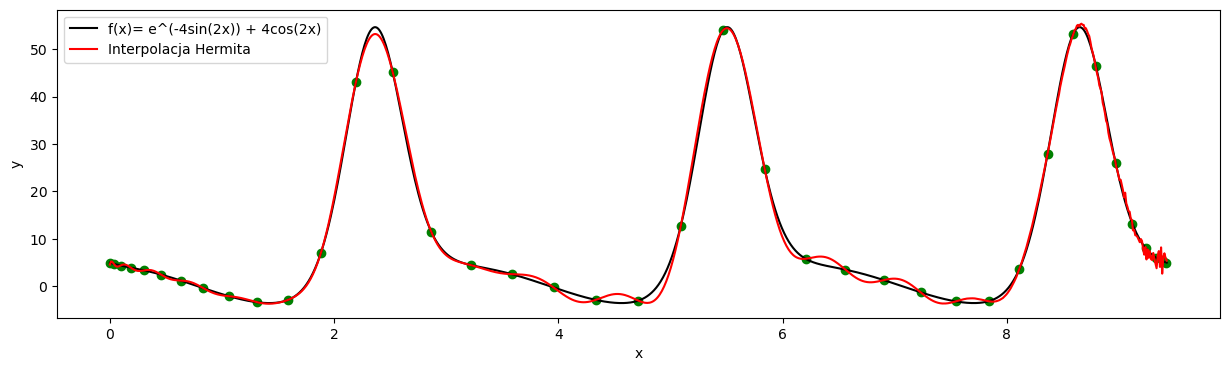

In [23]:
def derivative(x, n):
    return list(map(lambda f: f(x), derivatives[:n+1]))

n = 39
x = czebyszew_node(a, b, n)
y = [derivative(xi, 0) for xi in x]
plot_interpolation(g, x, y)

In [24]:
def test_hermit(n, d=1):
    x_eq = np.linspace(a,b,n)
    y_eq = [derivative(float(xi), d) for xi in x_eq]

    xc = czebyszew_node(a,b,n)
    yc = [derivative(float(xi), d) for xi in xc]

    plot_interpolation(g, x_eq, y_eq, title=f"Węzły równomiernie rozłozone, {n} wezlow", show_err=True)
    plot_interpolation(g, xc, yc, title=f"Węzły z rozkładem Czebyszewa, {n} wezlow", show_err=True)


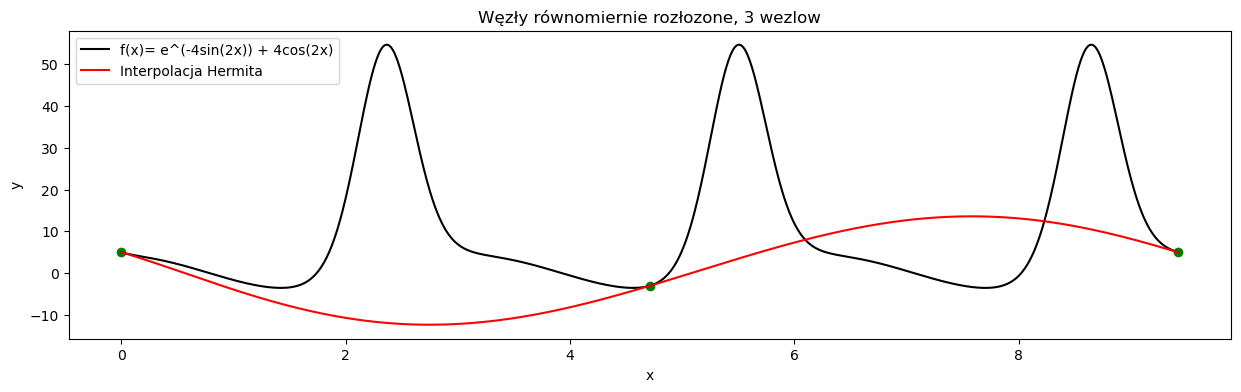

╒════════════════════════╤═════════════════════════════════════╕
│                        │   Interpolacja Interpolacja Hermita │
│                        │                                     │
╞════════════════════════╪═════════════════════════════════════╡
│ Błąd bezwzględny:      │                           66.528471 │
├────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów róznic: │                       503508.852021 │
╘════════════════════════╧═════════════════════════════════════╛


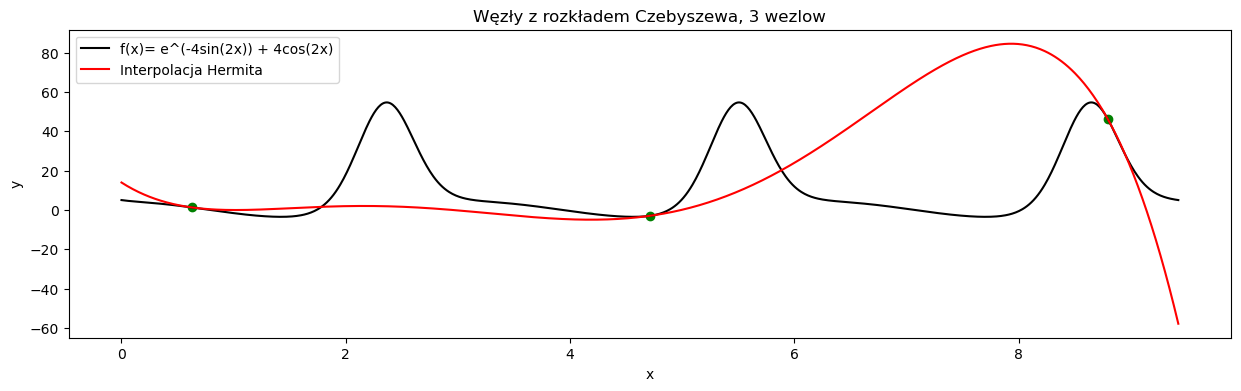

╒════════════════════════╤═════════════════════════════════════╕
│                        │   Interpolacja Interpolacja Hermita │
│                        │                                     │
╞════════════════════════╪═════════════════════════════════════╡
│ Błąd bezwzględny:      │                           87.252654 │
├────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów róznic: │                      1334373.781006 │
╘════════════════════════╧═════════════════════════════════════╛


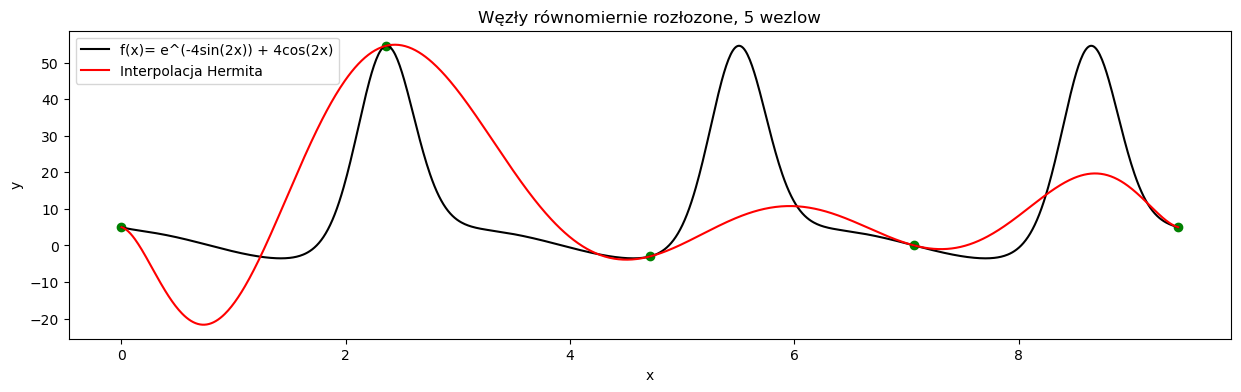

╒════════════════════════╤═════════════════════════════════════╕
│                        │   Interpolacja Interpolacja Hermita │
│                        │                                     │
╞════════════════════════╪═════════════════════════════════════╡
│ Błąd bezwzględny:      │                           46.875472 │
├────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów róznic: │                       321653.294803 │
╘════════════════════════╧═════════════════════════════════════╛


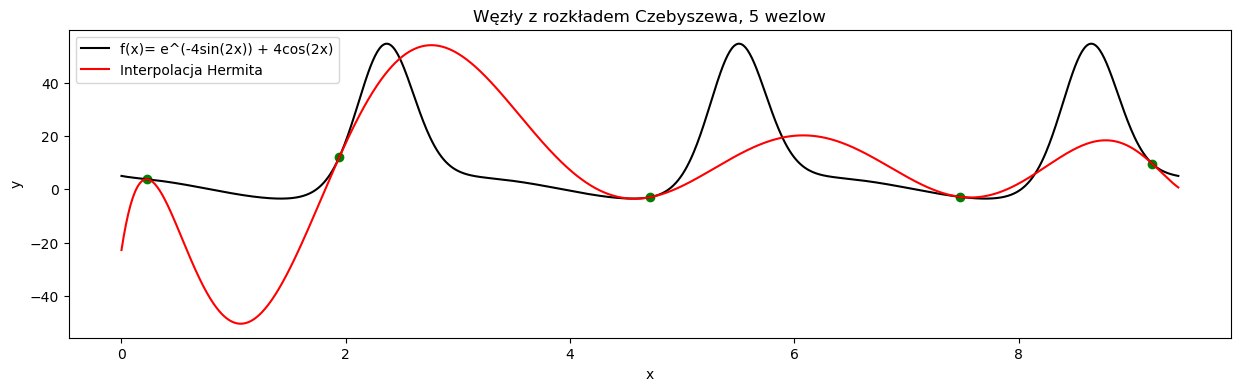

╒════════════════════════╤═════════════════════════════════════╕
│                        │   Interpolacja Interpolacja Hermita │
│                        │                                     │
╞════════════════════════╪═════════════════════════════════════╡
│ Błąd bezwzględny:      │                           48.498764 │
├────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów róznic: │                       473469.849325 │
╘════════════════════════╧═════════════════════════════════════╛


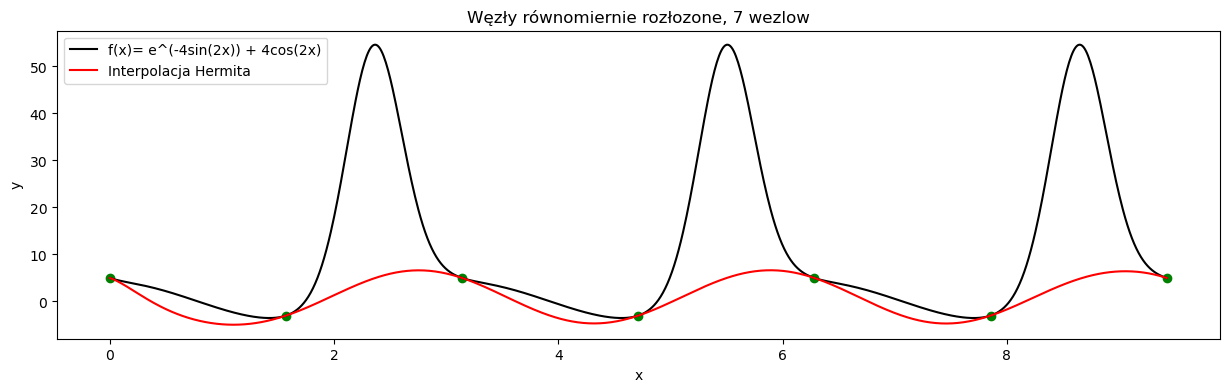

╒════════════════════════╤═════════════════════════════════════╕
│                        │   Interpolacja Interpolacja Hermita │
│                        │                                     │
╞════════════════════════╪═════════════════════════════════════╡
│ Błąd bezwzględny:      │                           49.826981 │
├────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów róznic: │                       337958.497001 │
╘════════════════════════╧═════════════════════════════════════╛


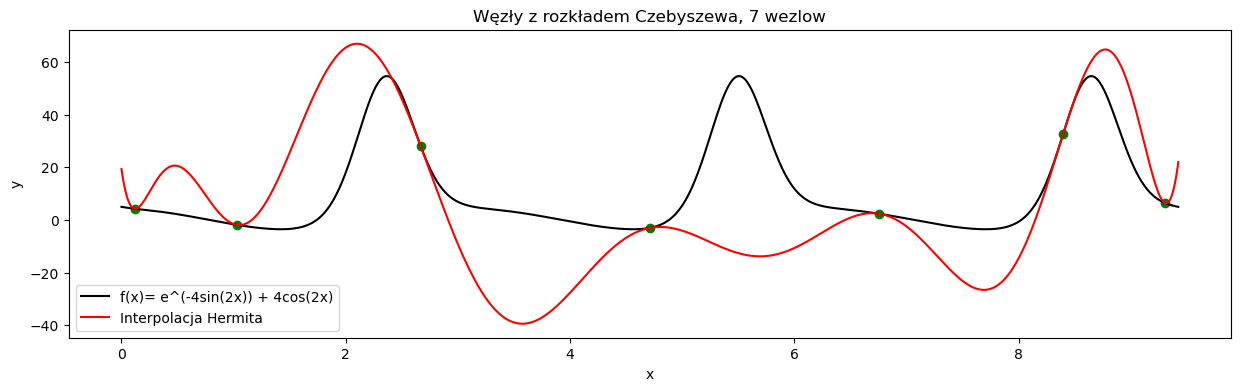

╒════════════════════════╤═════════════════════════════════════╕
│                        │   Interpolacja Interpolacja Hermita │
│                        │                                     │
╞════════════════════════╪═════════════════════════════════════╡
│ Błąd bezwzględny:      │                           67.370701 │
├────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów róznic: │                       617969.688156 │
╘════════════════════════╧═════════════════════════════════════╛


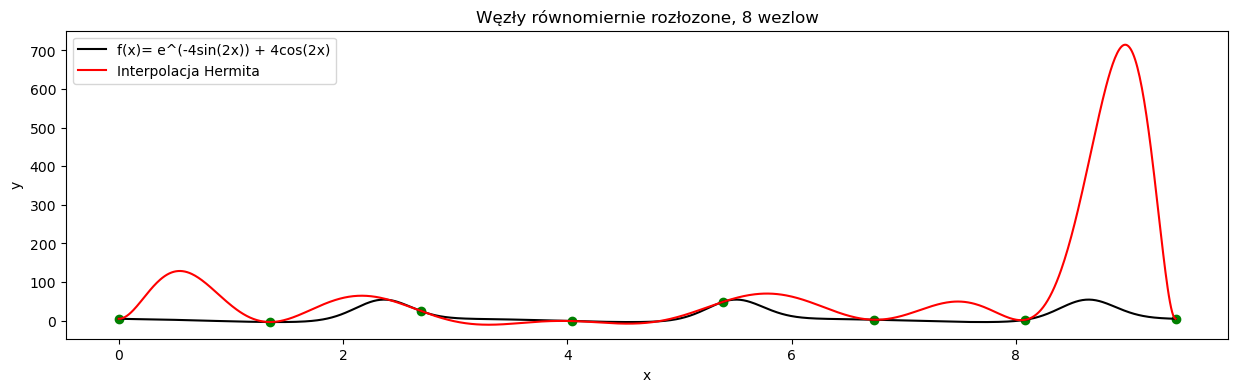

╒════════════════════════╤═════════════════════════════════════╕
│                        │   Interpolacja Interpolacja Hermita │
│                        │                                     │
╞════════════════════════╪═════════════════════════════════════╡
│ Błąd bezwzględny:      │                          689.917126 │
├────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów róznic: │                     24016684.417666 │
╘════════════════════════╧═════════════════════════════════════╛


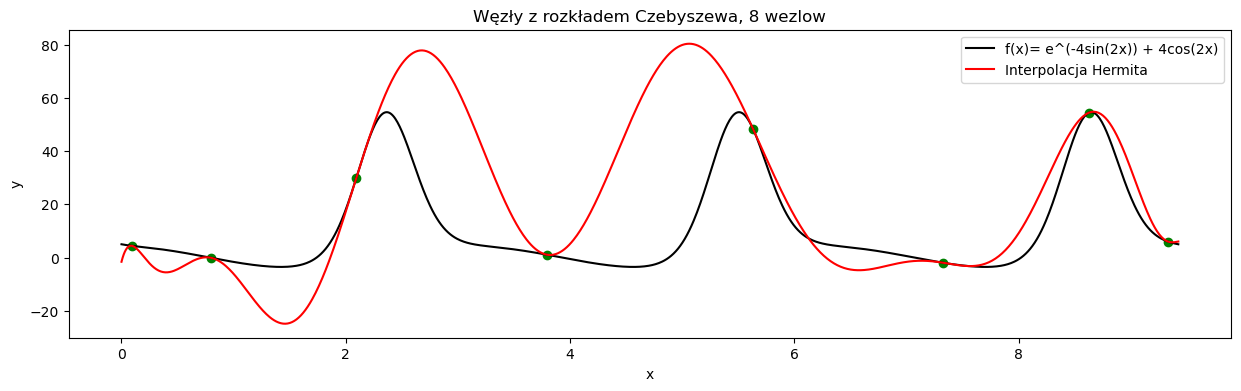

╒════════════════════════╤═════════════════════════════════════╕
│                        │   Interpolacja Interpolacja Hermita │
│                        │                                     │
╞════════════════════════╪═════════════════════════════════════╡
│ Błąd bezwzględny:      │                           76.580117 │
├────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów róznic: │                       683344.539871 │
╘════════════════════════╧═════════════════════════════════════╛


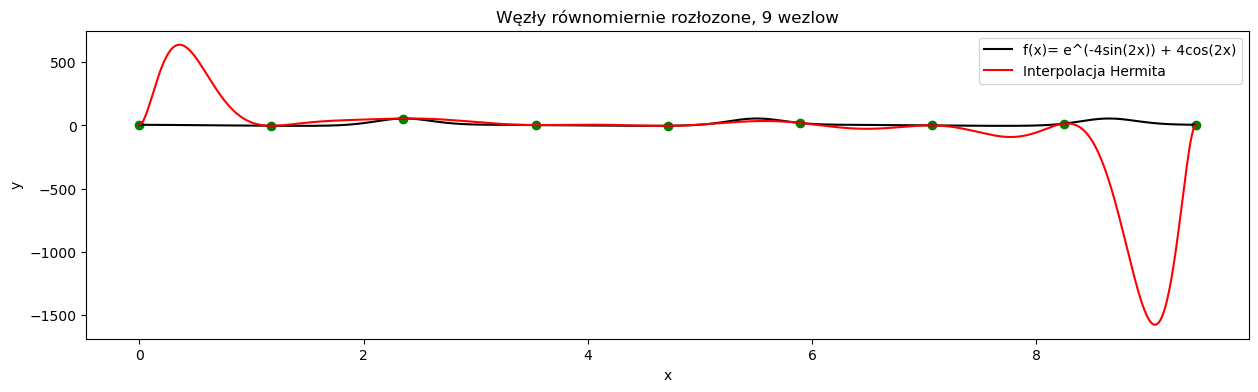

╒════════════════════════╤═════════════════════════════════════╕
│                        │   Interpolacja Interpolacja Hermita │
│                        │                                     │
╞════════════════════════╪═════════════════════════════════════╡
│ Błąd bezwzględny:      │                         1594.119267 │
├────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów róznic: │                    123919478.617692 │
╘════════════════════════╧═════════════════════════════════════╛


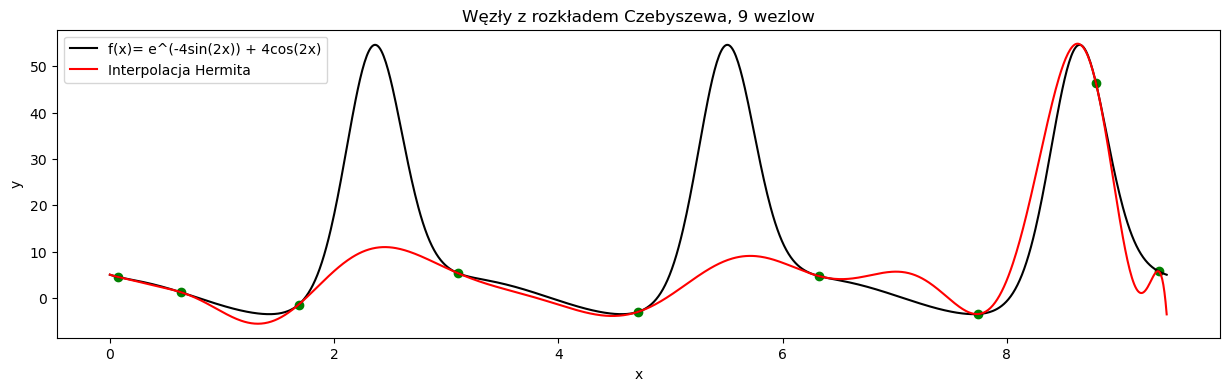

╒════════════════════════╤═════════════════════════════════════╕
│                        │   Interpolacja Interpolacja Hermita │
│                        │                                     │
╞════════════════════════╪═════════════════════════════════════╡
│ Błąd bezwzględny:      │                           46.520258 │
├────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów róznic: │                       187399.191258 │
╘════════════════════════╧═════════════════════════════════════╛


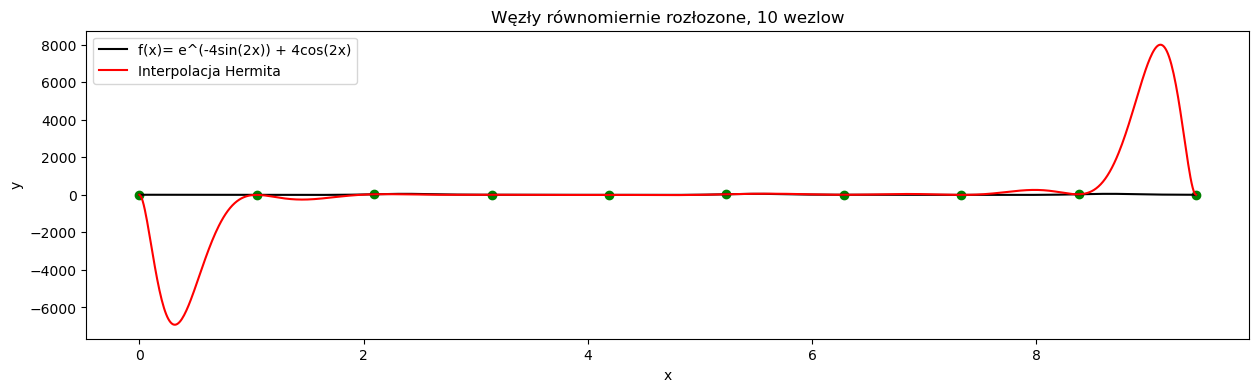

╒════════════════════════╤═════════════════════════════════════╕
│                        │   Interpolacja Interpolacja Hermita │
│                        │                                     │
╞════════════════════════╪═════════════════════════════════════╡
│ Błąd bezwzględny:      │                         7986.896806 │
├────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów róznic: │                   4070632495.977743 │
╘════════════════════════╧═════════════════════════════════════╛


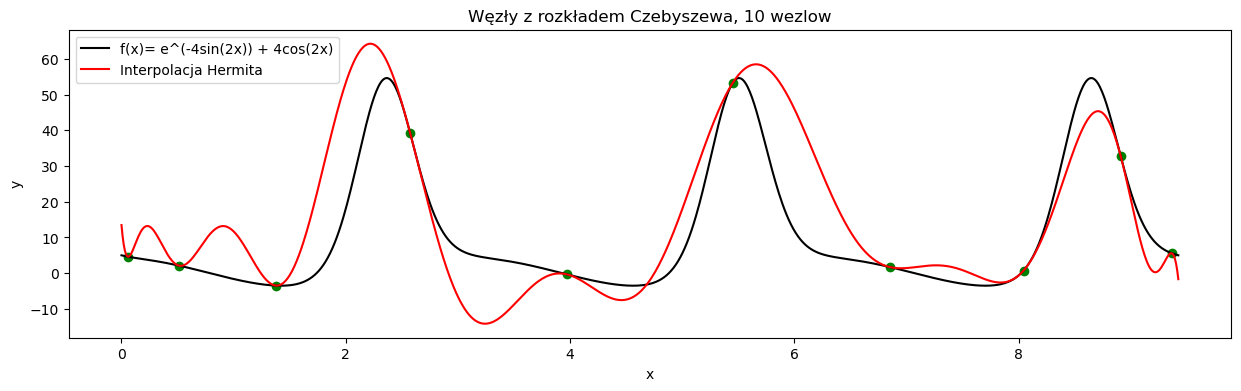

╒════════════════════════╤═════════════════════════════════════╕
│                        │   Interpolacja Interpolacja Hermita │
│                        │                                     │
╞════════════════════════╪═════════════════════════════════════╡
│ Błąd bezwzględny:      │                           35.584744 │
├────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów róznic: │                       152144.468670 │
╘════════════════════════╧═════════════════════════════════════╛


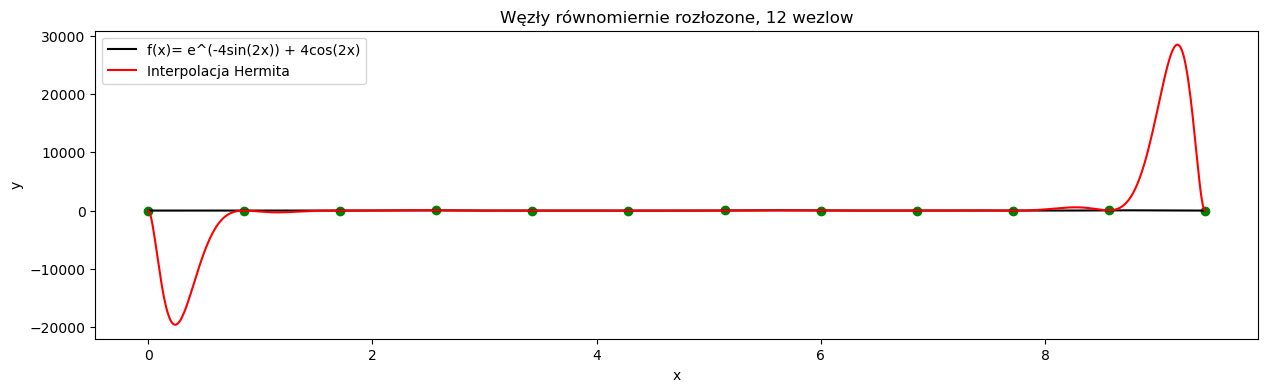

╒════════════════════════╤═════════════════════════════════════╕
│                        │   Interpolacja Interpolacja Hermita │
│                        │                                     │
╞════════════════════════╪═════════════════════════════════════╡
│ Błąd bezwzględny:      │                        28439.771309 │
├────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów róznic: │                  33983077577.985180 │
╘════════════════════════╧═════════════════════════════════════╛


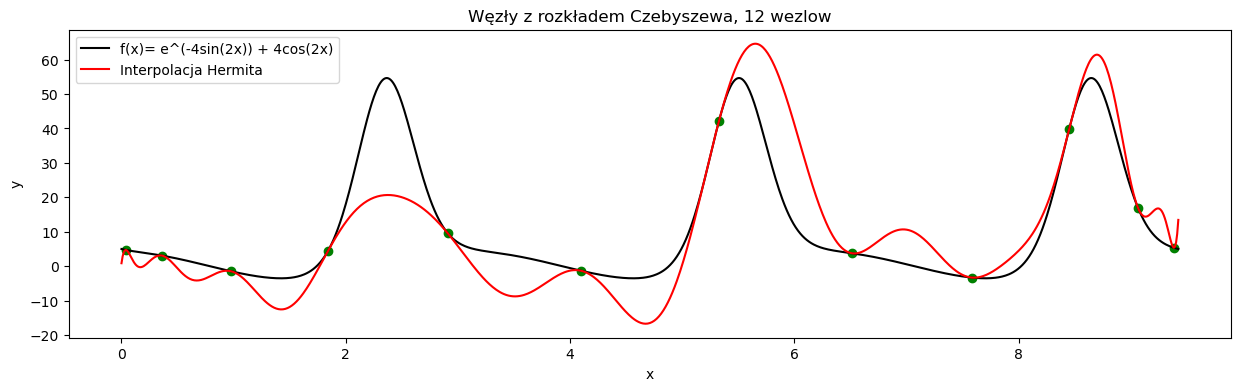

╒════════════════════════╤═════════════════════════════════════╕
│                        │   Interpolacja Interpolacja Hermita │
│                        │                                     │
╞════════════════════════╪═════════════════════════════════════╡
│ Błąd bezwzględny:      │                           33.962591 │
├────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów róznic: │                       117524.183562 │
╘════════════════════════╧═════════════════════════════════════╛


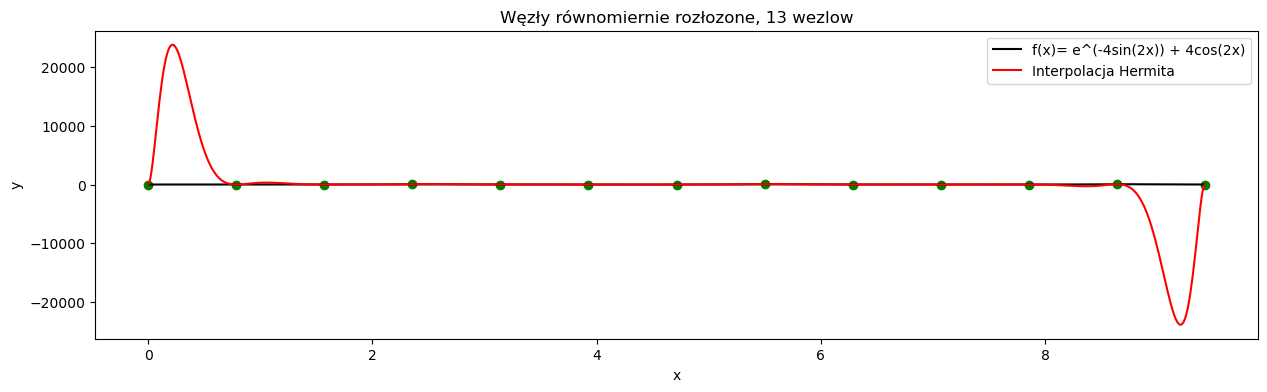

╒════════════════════════╤═════════════════════════════════════╕
│                        │   Interpolacja Interpolacja Hermita │
│                        │                                     │
╞════════════════════════╪═════════════════════════════════════╡
│ Błąd bezwzględny:      │                        23890.371791 │
├────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów róznic: │                  29184373723.464996 │
╘════════════════════════╧═════════════════════════════════════╛


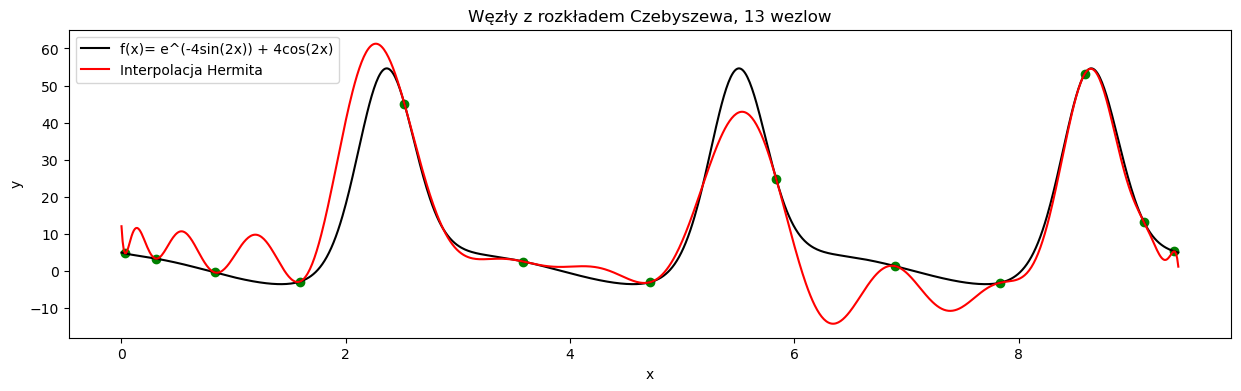

╒════════════════════════╤═════════════════════════════════════╕
│                        │   Interpolacja Interpolacja Hermita │
│                        │                                     │
╞════════════════════════╪═════════════════════════════════════╡
│ Błąd bezwzględny:      │                           23.049806 │
├────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów róznic: │                        48412.963567 │
╘════════════════════════╧═════════════════════════════════════╛


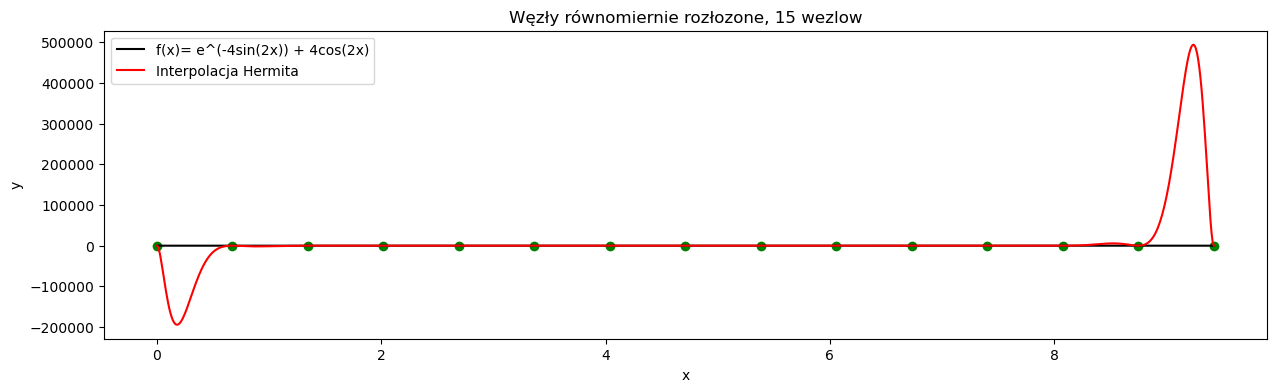

╒════════════════════════╤═════════════════════════════════════╕
│                        │   Interpolacja Interpolacja Hermita │
│                        │                                     │
╞════════════════════════╪═════════════════════════════════════╡
│ Błąd bezwzględny:      │                       494034.441732 │
├────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów róznic: │                6093124029473.718750 │
╘════════════════════════╧═════════════════════════════════════╛


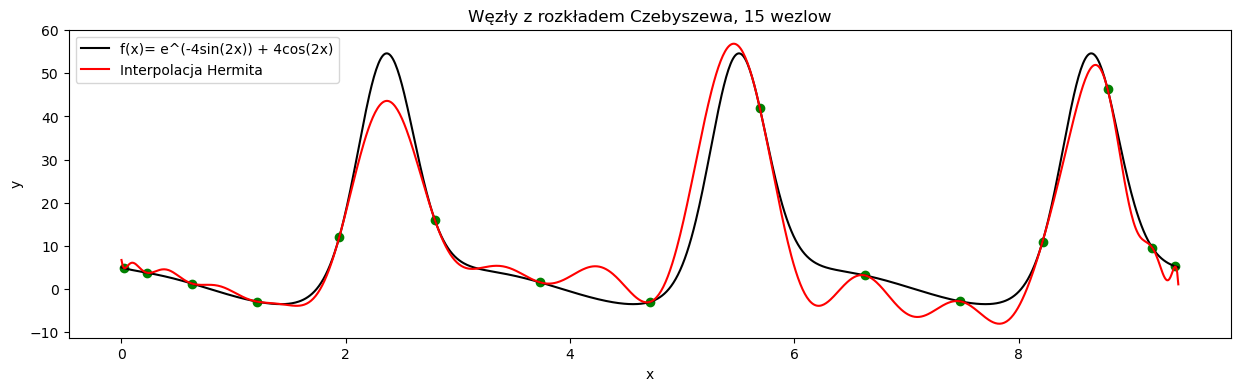

╒════════════════════════╤═════════════════════════════════════╕
│                        │   Interpolacja Interpolacja Hermita │
│                        │                                     │
╞════════════════════════╪═════════════════════════════════════╡
│ Błąd bezwzględny:      │                           14.021890 │
├────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów róznic: │                        19633.494619 │
╘════════════════════════╧═════════════════════════════════════╛


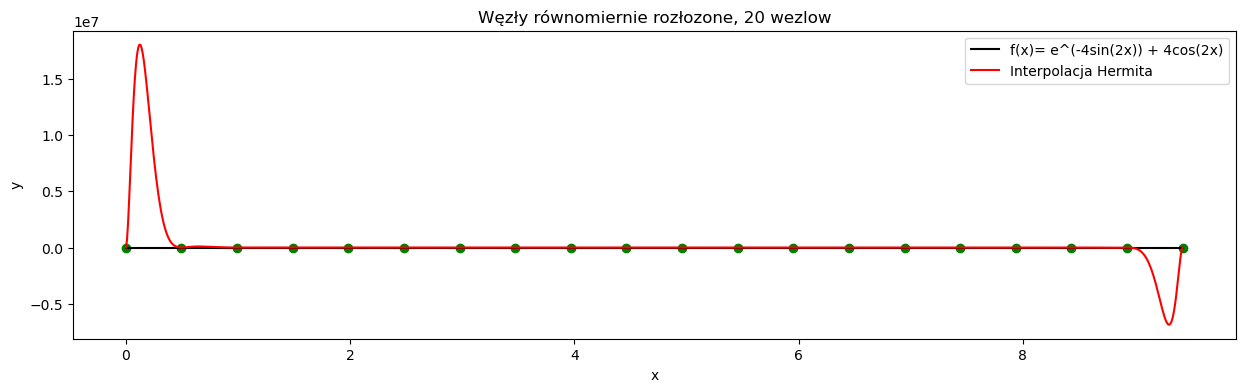

╒════════════════════════╤═════════════════════════════════════╕
│                        │   Interpolacja Interpolacja Hermita │
│                        │                                     │
╞════════════════════════╪═════════════════════════════════════╡
│ Błąd bezwzględny:      │                     18039722.158487 │
├────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów róznic: │             5602362038436867.000000 │
╘════════════════════════╧═════════════════════════════════════╛


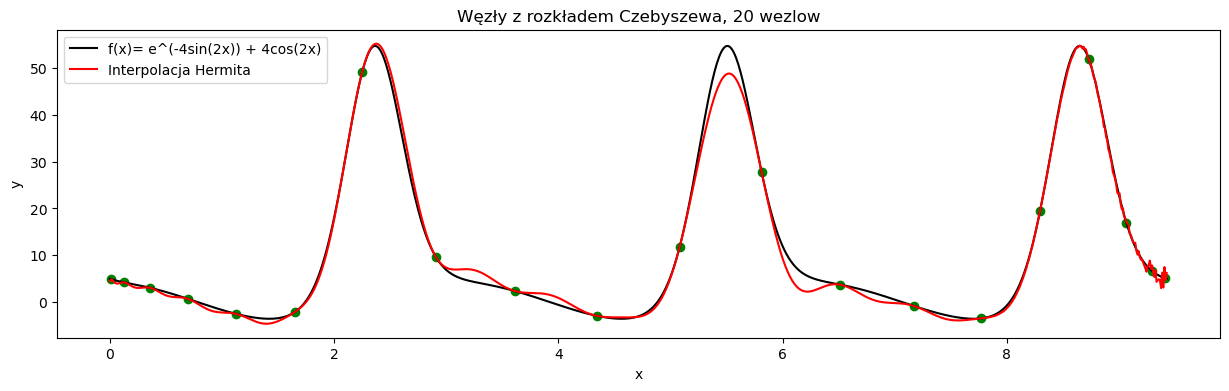

╒════════════════════════╤═════════════════════════════════════╕
│                        │   Interpolacja Interpolacja Hermita │
│                        │                                     │
╞════════════════════════╪═════════════════════════════════════╡
│ Błąd bezwzględny:      │                            6.097894 │
├────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów róznic: │                         2044.556036 │
╘════════════════════════╧═════════════════════════════════════╛


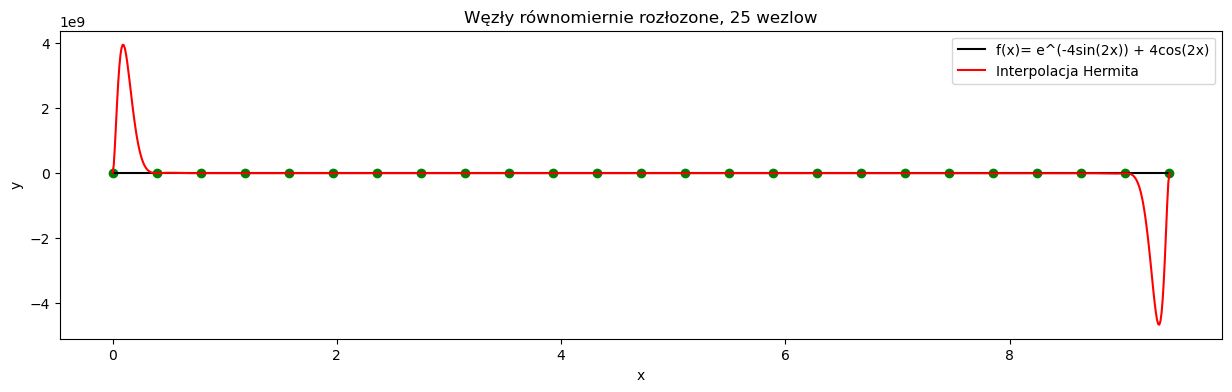

╒════════════════════════╤═════════════════════════════════════╕
│                        │   Interpolacja Interpolacja Hermita │
│                        │                                     │
╞════════════════════════╪═════════════════════════════════════╡
│ Błąd bezwzględny:      │                   4663644154.955416 │
├────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów róznic: │        428049625804603064320.000000 │
╘════════════════════════╧═════════════════════════════════════╛


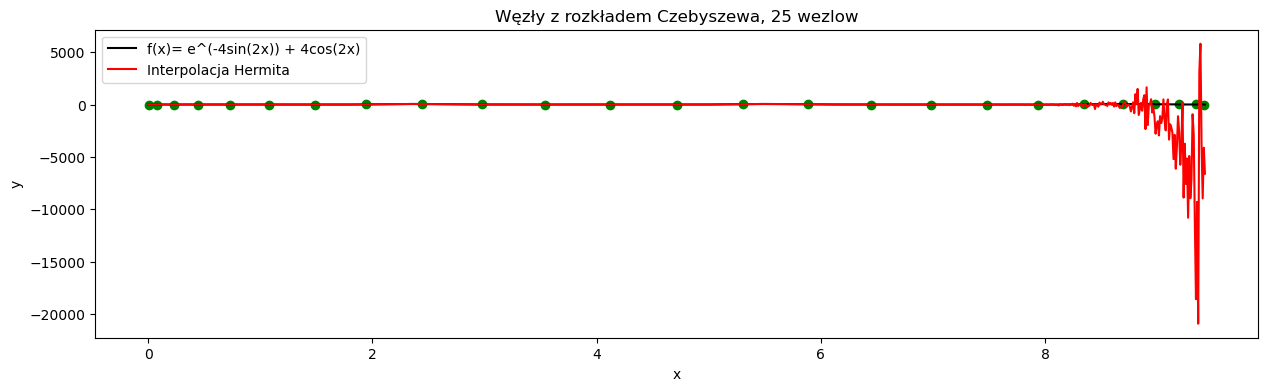

╒════════════════════════╤═════════════════════════════════════╕
│                        │   Interpolacja Interpolacja Hermita │
│                        │                                     │
╞════════════════════════╪═════════════════════════════════════╡
│ Błąd bezwzględny:      │                        15057.981639 │
├────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów róznic: │                   1191721469.004399 │
╘════════════════════════╧═════════════════════════════════════╛


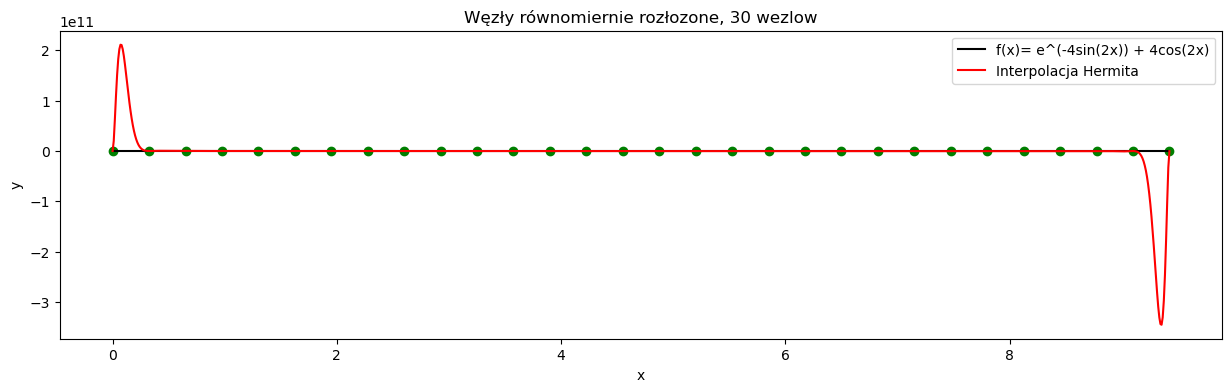

╒════════════════════════╤═════════════════════════════════════╕
│                        │   Interpolacja Interpolacja Hermita │
│                        │                                     │
╞════════════════════════╪═════════════════════════════════════╡
│ Błąd bezwzględny:      │                 346032592003.259827 │
├────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów róznic: │    1514776332512612554113024.000000 │
╘════════════════════════╧═════════════════════════════════════╛


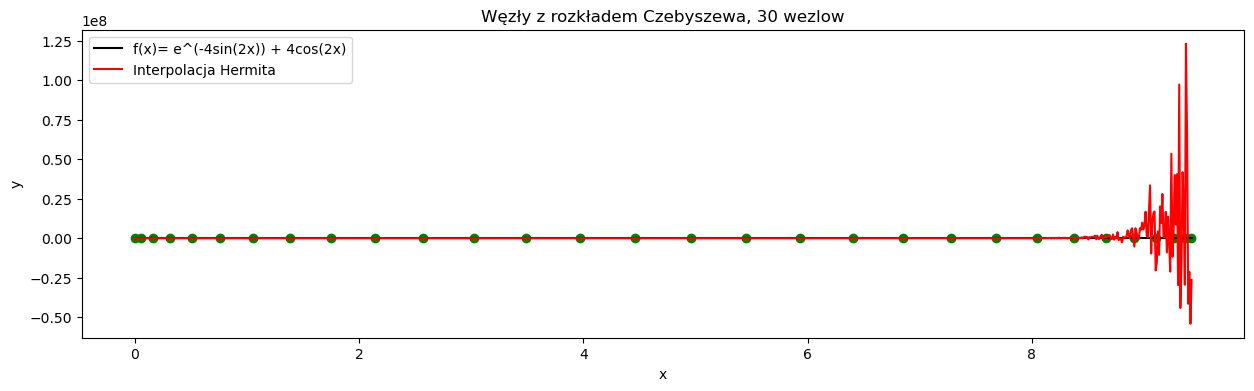

╒════════════════════════╤═════════════════════════════════════╕
│                        │   Interpolacja Interpolacja Hermita │
│                        │                                     │
╞════════════════════════╪═════════════════════════════════════╡
│ Błąd bezwzględny:      │                    126314338.806517 │
├────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów róznic: │            73762885368808944.000000 │
╘════════════════════════╧═════════════════════════════════════╛


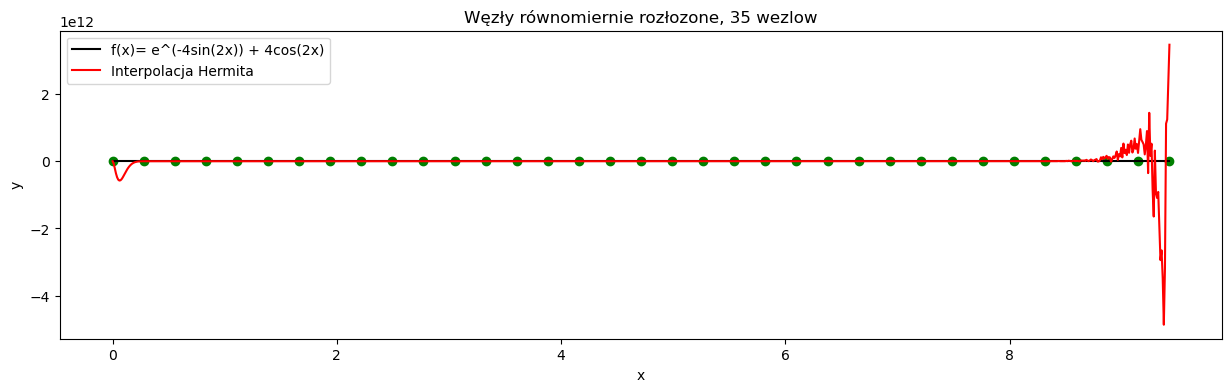

╒════════════════════════╤═════════════════════════════════════╕
│                        │   Interpolacja Interpolacja Hermita │
│                        │                                     │
╞════════════════════════╪═════════════════════════════════════╡
│ Błąd bezwzględny:      │                5504769906993.533203 │
├────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów róznic: │  133599336319176078291632128.000000 │
╘════════════════════════╧═════════════════════════════════════╛


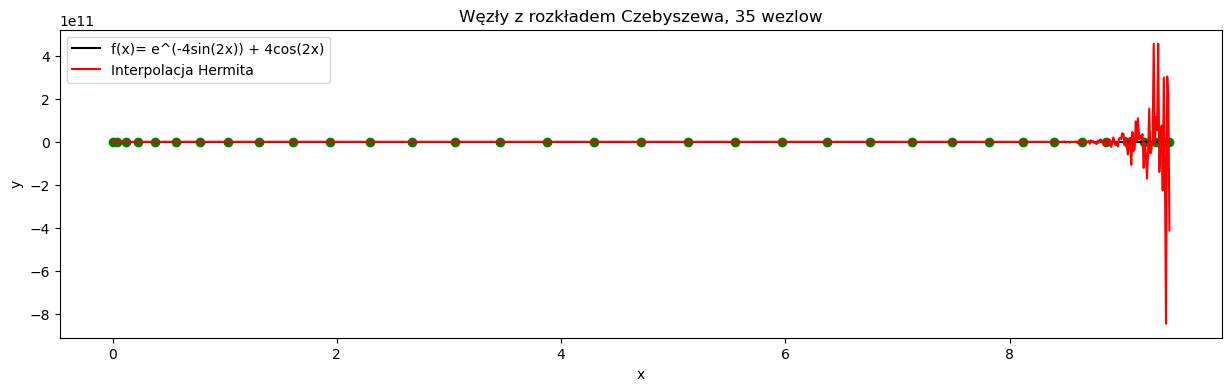

╒════════════════════════╤═════════════════════════════════════╕
│                        │   Interpolacja Interpolacja Hermita │
│                        │                                     │
╞════════════════════════╪═════════════════════════════════════╡
│ Błąd bezwzględny:      │                 553972688903.761475 │
├────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów róznic: │    1414401638249297583538176.000000 │
╘════════════════════════╧═════════════════════════════════════╛


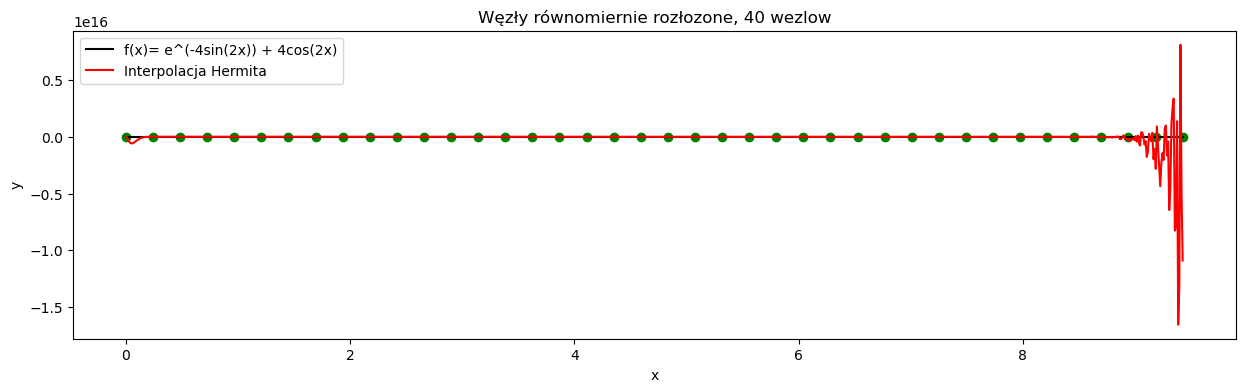

╒════════════════════════╤══════════════════════════════════════════╕
│                        │        Interpolacja Interpolacja Hermita │
│                        │                                          │
╞════════════════════════╪══════════════════════════════════════════╡
│ Błąd bezwzględny:      │                 12838267021070158.000000 │
├────────────────────────┼──────────────────────────────────────────┤
│ Suma kwadratów róznic: │ 643614022841987975302488906530816.000000 │
╘════════════════════════╧══════════════════════════════════════════╛


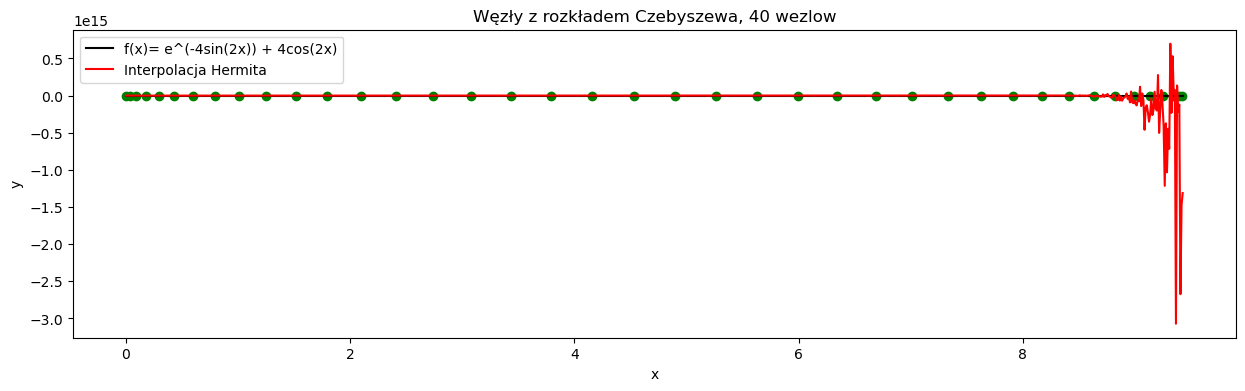

╒════════════════════════╤═════════════════════════════════════════╕
│                        │       Interpolacja Interpolacja Hermita │
│                        │                                         │
╞════════════════════════╪═════════════════════════════════════════╡
│ Błąd bezwzględny:      │                 2867107548360963.000000 │
├────────────────────────┼─────────────────────────────────────────┤
│ Suma kwadratów róznic: │ 26984591560752951107177685188608.000000 │
╘════════════════════════╧═════════════════════════════════════════╛


In [31]:
tests = [3,5,7,8,9,10,12,13,15,20,25,30,35,40]

for i in tests:
    test_hermit(i)

In [26]:
def find_best_poly(max_n, node_fun, criteria=mean_square_error, N=1000):
    best_err = float('inf')
    best_n = -1
    x_err_pt = np.linspace(a,b,N)
    
    for n in range(2, max_n+1):
        x = node_fun(a,b,n)
        y = [derivative(float(xi), 1) for xi in x]

        W = hermit(x,y)
        err = criteria(g,W, x_err_pt)
        if err<best_err:
            best_err, best_n = err, n
    print(f"Stopien wielomianu: {best_n}, błąd:{best_err}")

In [27]:
find_best_poly(50, np.linspace)

Stopien wielomianu: 5, błąd:321653.2948028965


In [28]:
find_best_poly(50, czebyszew_node)

Stopien wielomianu: 20, błąd:2044.556036333227


In [29]:
find_best_poly(100, czebyszew_node)

Stopien wielomianu: 20, błąd:2044.556036333227


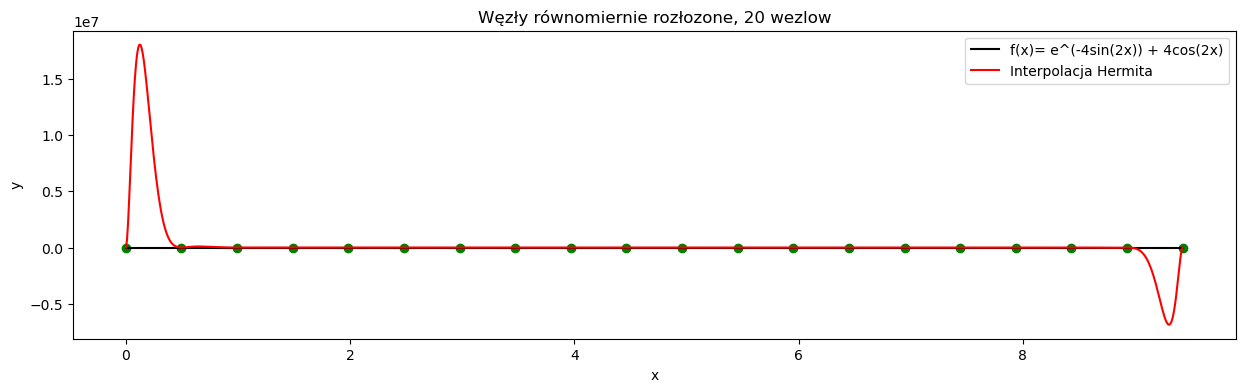

╒════════════════════════╤═════════════════════════════════════╕
│                        │   Interpolacja Interpolacja Hermita │
│                        │                                     │
╞════════════════════════╪═════════════════════════════════════╡
│ Błąd bezwzględny:      │                     18039722.158487 │
├────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów róznic: │             5602362038436867.000000 │
╘════════════════════════╧═════════════════════════════════════╛


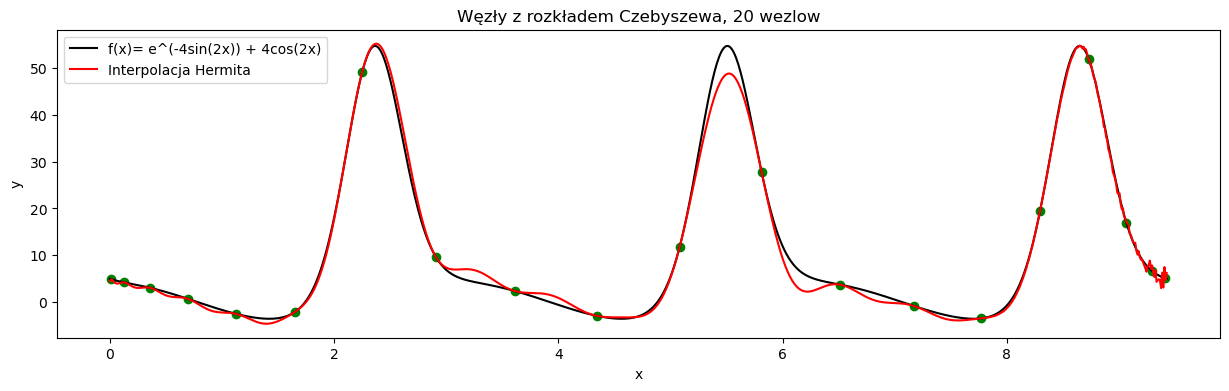

╒════════════════════════╤═════════════════════════════════════╕
│                        │   Interpolacja Interpolacja Hermita │
│                        │                                     │
╞════════════════════════╪═════════════════════════════════════╡
│ Błąd bezwzględny:      │                            6.097894 │
├────────────────────────┼─────────────────────────────────────┤
│ Suma kwadratów róznic: │                         2044.556036 │
╘════════════════════════╧═════════════════════════════════════╛


In [30]:
test_hermit(20)